## DDPM vs DDIM 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
# from diffusers import StableDiffusion3Pipeline
from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline
from diffusers import EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler, LMSDiscreteScheduler
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl import retrieve_timesteps

In [2]:
# model_id = "stabilityai/stable-diffusion-2"
# model_id = "stabilityai/stable-diffusion-2-1" #Pretty nice samples
# model_id = "runwayml/stable-diffusion-v1-5"   #Uses epsilon sampler, images are pretty crappy
# model_id = "CompVis/stable-diffusion-v1-4" #Also pretty crappy
model_id = "stabilityai/stable-diffusion-xl-base-1.0" #Maybe less crappy? Yeah not bad! Wwhat's the scheduler? epsilon! How does it do with DDPM?
#Ok, xl-base is not bad with DDPM! Now, DDIM? Yep! Ok let's make this the plan then, I think epsilon is going to make life simpler. 

# Picking a scheduler
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler") #Woah so different!
# scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler") 
# scheduler = LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler") 
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler") 
# scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler") 
# pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
# pipe = pipe.to("cuda")

# For stable diffusion xl 1.0
# pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe = DiffusionPipeline.from_pretrained(model_id, scheduler=scheduler,torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda");

# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
# prompt = "a photo of an astronaut riding a horse on the moon"
# prompt = "a photo of an astronaut riding a horse on mars"
# prompt="A lone tree standing in the middle of a desert, under the harsh light of midday, casting a long shadow on the sand."

In [4]:
# image = pipe(prompt, guidance=5.0).images[0]  
# image

## Configuration

Break into `pipeline_stable_diffusion_xl.py`

In [5]:
prompt = "a photo of an astronaut riding a horse on the moon"
prompt_2 = None
height = None
width = None
num_inference_steps = 50
timesteps  = None
sigmas = None
denoising_end = None
guidance_scale = 5.0
negative_prompt = None
negative_prompt_2 = None
num_images_per_prompt = 1
eta = 0.0
# generator = None
latents = None
prompt_embeds = None
negative_prompt_embeds= None
pooled_prompt_embeds= None
negative_pooled_prompt_embeds = None
ip_adapter_image = None
ip_adapter_image_embeds = None
output_type = "pil"
return_dict = True
cross_attention_kwargs = None
guidance_rescale = 0.0
original_size = None
crops_coords_top_left = (0, 0)
target_size = None
negative_original_size = None
negative_crops_coords_top_left = (0, 0)
negative_target_size = None
clip_skip  = None
callback_on_step_end = None
callback_on_step_end_tensor_inputs = ["latents"]

In [6]:
#Actually let's try fixing the seed. 
generator = torch.Generator(device="cuda").manual_seed(8)

## Setup for Denoising

In [7]:
# 0. Default height and width to unet
height = height or pipe.default_sample_size * pipe.vae_scale_factor
width = width or pipe.default_sample_size * pipe.vae_scale_factor

original_size = original_size or (height, width)
target_size = target_size or (height, width)

pipe._guidance_scale = guidance_scale
pipe._guidance_rescale = guidance_rescale
pipe._clip_skip = clip_skip
pipe._cross_attention_kwargs = cross_attention_kwargs
pipe._denoising_end = denoising_end
pipe._interrupt = False

batch_size = 1
device = pipe._execution_device

# 3. Encode input prompt
lora_scale = (pipe.cross_attention_kwargs.get("scale", None) if pipe.cross_attention_kwargs is not None else None)

with torch.no_grad():
    (
    prompt_embeds,
    negative_prompt_embeds,
    pooled_prompt_embeds,
    negative_pooled_prompt_embeds,
    ) = pipe.encode_prompt(
        prompt=prompt,
        prompt_2=prompt_2,
        device=device,
        num_images_per_prompt=num_images_per_prompt,
        do_classifier_free_guidance=pipe.do_classifier_free_guidance,
        negative_prompt=negative_prompt,
        negative_prompt_2=negative_prompt_2,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        pooled_prompt_embeds=pooled_prompt_embeds,
        negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
        lora_scale=lora_scale,
        clip_skip=pipe.clip_skip,
    )

    # 4. Prepare timesteps
    timesteps, num_inference_steps = retrieve_timesteps(
        pipe.scheduler, num_inference_steps, device, timesteps, sigmas
    )

    # 5. Prepare latent variables
    num_channels_latents = pipe.unet.config.in_channels
    latents = pipe.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        prompt_embeds.dtype,
        device,
        generator,
        latents,
    )

    # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)

    # 7. Prepare added time ids & embeddings
    add_text_embeds = pooled_prompt_embeds
    if pipe.text_encoder_2 is None:
        text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
    else:
        text_encoder_projection_dim = pipe.text_encoder_2.config.projection_dim
    
    add_time_ids = pipe._get_add_time_ids(
        original_size,
        crops_coords_top_left,
        target_size,
        dtype=prompt_embeds.dtype,
        text_encoder_projection_dim=text_encoder_projection_dim,
    )
    if negative_original_size is not None and negative_target_size is not None:
        negative_add_time_ids = pipe._get_add_time_ids(
            negative_original_size,
            negative_crops_coords_top_left,
            negative_target_size,
            dtype=prompt_embeds.dtype,
            text_encoder_projection_dim=text_encoder_projection_dim,
        )
    else:
        negative_add_time_ids = add_time_ids
    
    if pipe.do_classifier_free_guidance:
        prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
        add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
        add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)
    
    prompt_embeds = prompt_embeds.to(device)
    add_text_embeds = add_text_embeds.to(device)
    add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)
    
    if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
        image_embeds = self.prepare_ip_adapter_image_embeds(
            ip_adapter_image,
            ip_adapter_image_embeds,
            device,
            batch_size * num_images_per_prompt,
            pipe.do_classifier_free_guidance,
        )

    # 8. Denoising loop
    num_warmup_steps = max(len(timesteps) - num_inference_steps * pipe.scheduler.order, 0)
    
    # 8.1 Apply denoising_end
    if (
        pipe.denoising_end is not None
        and isinstance(self.denoising_end, float)
        and pipe.denoising_end > 0
        and pipe.denoising_end < 1
    ):
        discrete_timestep_cutoff = int(
            round(
                pipe.scheduler.config.num_train_timesteps
                - (pipe.denoising_end * self.scheduler.config.num_train_timesteps)
            )
        )
        num_inference_steps = len(list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps)))
        timesteps = timesteps[:num_inference_steps]
    
    # 9. Optionally get Guidance Scale Embedding
    timestep_cond = None
    if pipe.unet.config.time_cond_proj_dim is not None:
        guidance_scale_tensor = torch.tensor(pipe.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
        timestep_cond = pipe.get_guidance_scale_embedding(
            guidance_scale_tensor, embedding_dim=pipe.unet.config.time_cond_proj_dim
        ).to(device=device, dtype=latents.dtype)

## Denoising Loop

In [8]:
with torch.no_grad():
    pipe._num_timesteps = len(timesteps)
    with pipe.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            if pipe.interrupt:
                continue
    
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if pipe.do_classifier_free_guidance else latents
    
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    
            # predict the noise residual
            added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                timestep_cond=timestep_cond,
                cross_attention_kwargs=pipe.cross_attention_kwargs,
                added_cond_kwargs=added_cond_kwargs,
                return_dict=False,
            )[0]
    
            # perform guidance
            if pipe.do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + pipe.guidance_scale * (noise_pred_text - noise_pred_uncond)
    
            # compute the previous noisy sample x_t -> x_t-1
            latents_dtype = latents.dtype
            # latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

            ## --- Break into pipe.scheduler.step ---- #
       
            model_output = noise_pred
            timestep = t
            sample = latents
            generator=generator
            return_dict = False
            t = timestep
            
            prev_t = pipe.scheduler.previous_timestep(t)
            
            if model_output.shape[1] == sample.shape[1] * 2 and pipe.scheduler.variance_type in ["learned", "learned_range"]:
                model_output, predicted_variance = torch.split(model_output, sample.shape[1], dim=1)
            else:
                predicted_variance = None
            
            # 1. compute alphas, betas
            alpha_prod_t = pipe.scheduler.alphas_cumprod[t]
            alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[prev_t] if prev_t >= 0 else pipe.scheduler.one
            beta_prod_t = 1 - alpha_prod_t
            beta_prod_t_prev = 1 - alpha_prod_t_prev
            current_alpha_t = alpha_prod_t / alpha_prod_t_prev
            current_beta_t = 1 - current_alpha_t
            
            # 2. compute predicted original sample from predicted noise also called
            # "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
            if pipe.scheduler.config.prediction_type == "epsilon":
                pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
            elif pipe.scheduler.config.prediction_type == "sample":
                pred_original_sample = model_output
            elif pipe.scheduler.config.prediction_type == "v_prediction":
                pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
            else:
                raise ValueError(
                    f"prediction_type given as {pipe.scheduler.config.prediction_type} must be one of `epsilon`, `sample` or"
                    " `v_prediction`  for the DDPMScheduler."
                )
            
            # 3. Clip or threshold "predicted x_0"
            if pipe.scheduler.config.thresholding:
                pred_original_sample = pipe.scheduler._threshold_sample(pred_original_sample)
            elif pipe.scheduler.config.clip_sample:
                pred_original_sample = pred_original_sample.clamp(
                    -pipe.scheduler.config.clip_sample_range, pipe.scheduler.config.clip_sample_range
                )
            
            # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
            # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
            pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
            current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t
            
            # 5. Compute predicted previous sample µ_t
            # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
            pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample
            
            # 6. Add noise
            variance = 0
            if t > 0:
                device = model_output.device
                variance_noise = randn_tensor(
                    model_output.shape, generator=generator, device=device, dtype=model_output.dtype
                )
                if pipe.scheduler.variance_type == "fixed_small_log":
                    variance = pipe.scheduler._get_variance(t, predicted_variance=predicted_variance) * variance_noise
                elif pipe.scheduler.variance_type == "learned_range":
                    variance = pipe.scheduler._get_variance(t, predicted_variance=predicted_variance)
                    variance = torch.exp(0.5 * variance) * variance_noise
                else:
                    variance = (pipe.scheduler._get_variance(t, predicted_variance=predicted_variance) ** 0.5) * variance_noise
            
            pred_prev_sample = pred_prev_sample + variance
            
            latents =  pred_prev_sample

            ## ---- End pipe.scheduler ---- ##

            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                progress_bar.update()


  0%|          | 0/50 [00:00<?, ?it/s]

## VAE

In [9]:
with torch.no_grad():
    if not output_type == "latent":
        # make sure the VAE is in float32 mode, as it overflows in float16
        needs_upcasting = pipe.vae.dtype == torch.float16 and pipe.vae.config.force_upcast
    
        if needs_upcasting:
            pipe.upcast_vae()
            latents = latents.to(next(iter(pipe.vae.post_quant_conv.parameters())).dtype)
        elif latents.dtype != pipe.vae.dtype:
            if torch.backends.mps.is_available():
                # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
                pipe.vae = pipe.vae.to(latents.dtype)
    
        # unscale/denormalize the latents
        # denormalize with the mean and std if available and not None
        has_latents_mean = hasattr(pipe.vae.config, "latents_mean") and pipe.vae.config.latents_mean is not None
        has_latents_std = hasattr(pipe.vae.config, "latents_std") and pipe.vae.config.latents_std is not None
        if has_latents_mean and has_latents_std:
            latents_mean = (
                torch.tensor(pipe.vae.config.latents_mean).view(1, 4, 1, 1).to(latents.device, latents.dtype)
            )
            latents_std = (
                torch.tensor(pipe.vae.config.latents_std).view(1, 4, 1, 1).to(latents.device, latents.dtype)
            )
            latents = latents * latents_std / pipe.vae.config.scaling_factor + latents_mean
        else:
            latents = latents / pipe.vae.config.scaling_factor
    
        image = pipe.vae.decode(latents, return_dict=False)[0]
    
        # cast back to fp16 if needed
        if needs_upcasting:
            pipe.vae.to(dtype=torch.float16)

        image = pipe.image_processor.postprocess(image, output_type=output_type)

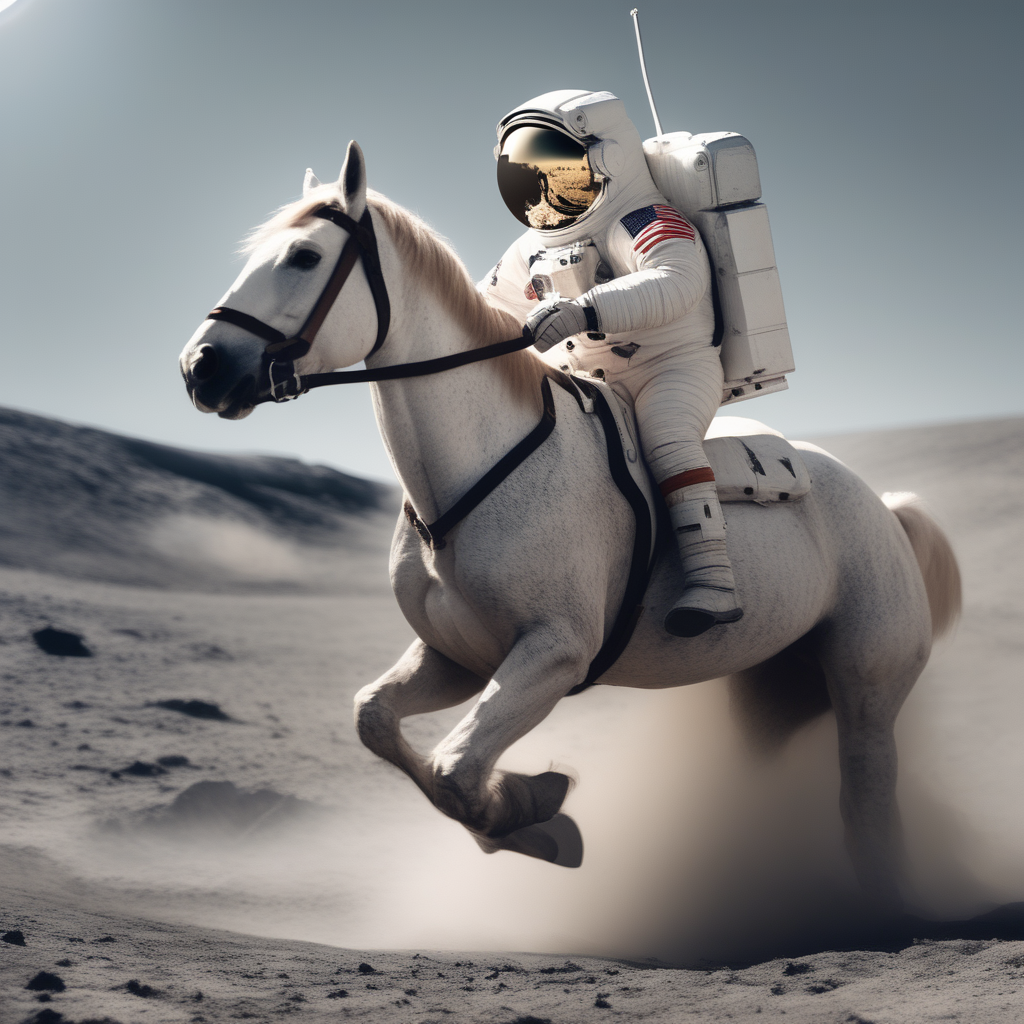

In [10]:
image[0]

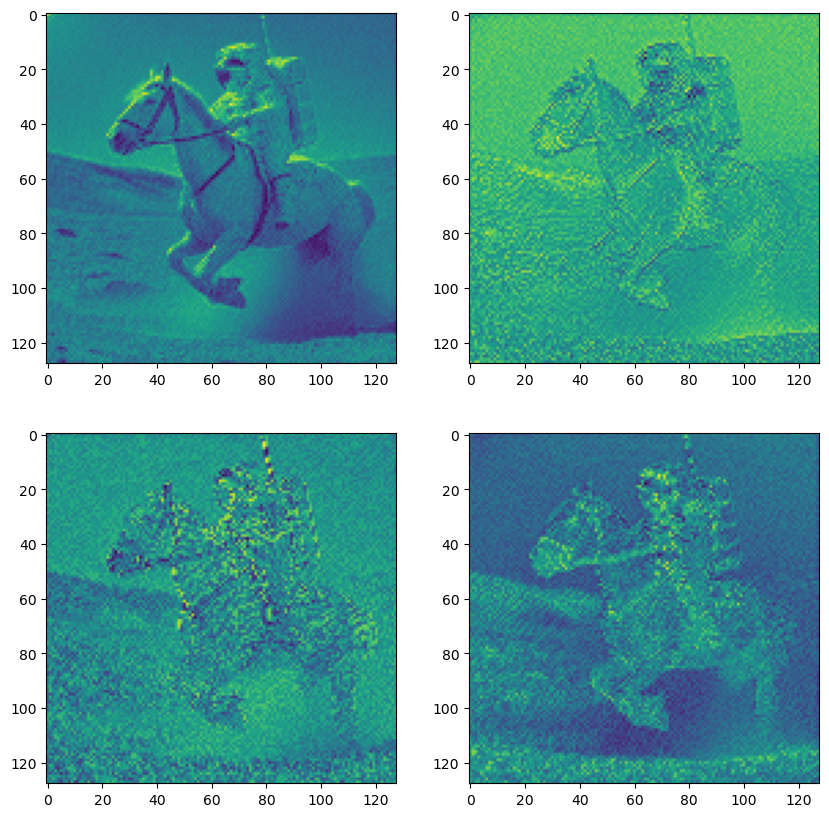

In [12]:
fig=plt.figure(0,(10,10))
fig.add_subplot(2,2,1); plt.imshow(latents.detach().cpu().numpy()[0,0])
fig.add_subplot(2,2,2); plt.imshow(latents.detach().cpu().numpy()[0,1])
fig.add_subplot(2,2,3); plt.imshow(latents.detach().cpu().numpy()[0,2])
fig.add_subplot(2,2,4); plt.imshow(latents.detach().cpu().numpy()[0,3])